In [108]:
!git clone https://github.com/adrset/car_data
!git clone https://github.com/adrset/lssn_data
#!git clone https://github.com/rslim087a/track

fatal: destination path 'car_data' already exists and is not an empty directory.
Cloning into 'lssn_data'...
remote: Enumerating objects: 13744, done.
remote: Counting objects: 100% (13744/13744), done.
remote: Compressing objects: 100% (13744/13744), done.
remote: Total 13744 (delta 0), reused 13744 (delta 0), pack-reused 0
Receiving objects: 100% (13744/13744), 173.61 MiB | 33.87 MiB/s, done.
Checking out files: 100% (13750/13750), done.


In [0]:
!ls

sample_data  track


In [0]:
!ls car_data

ls: cannot access 'car_data': No such file or directory


In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
import matplotlib.image as npimg
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D , MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [0]:
datadir = 'lssn_data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names= columns)
pd.set_option('display.max_colwidth', -1)

In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

In [0]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

In [164]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_01_26_14_34_08_915.jpg,left_2020_01_26_14_34_08_915.jpg,right_2020_01_26_14_34_08_915.jpg,0.000000,1.0,0,15.17358
1,center_2020_01_26_14_34_09_016.jpg,left_2020_01_26_14_34_09_016.jpg,right_2020_01_26_14_34_09_016.jpg,0.000000,1.0,0,16.30043
2,center_2020_01_26_14_34_09_117.jpg,left_2020_01_26_14_34_09_117.jpg,right_2020_01_26_14_34_09_117.jpg,0.000000,1.0,0,17.29991
3,center_2020_01_26_14_34_09_218.jpg,left_2020_01_26_14_34_09_218.jpg,right_2020_01_26_14_34_09_218.jpg,-0.273203,1.0,0,18.33719
4,center_2020_01_26_14_34_09_318.jpg,left_2020_01_26_14_34_09_318.jpg,right_2020_01_26_14_34_09_318.jpg,-0.342619,1.0,0,19.25360


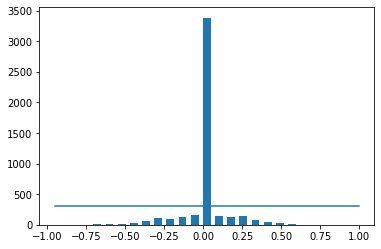

In [165]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) / 2.0
plt.bar(center, hist, width=0.05)
samples_per_bin = 300
plt.plot((np.min(data['steering']), max(data['steering'])), (samples_per_bin, samples_per_bin))


total data: 4583
removed: 3085


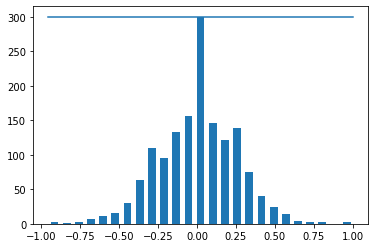

In [139]:
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [0]:
def load_img(data_dir, dataframe):
  img_path = []
  steering = []
  for i in range(len(data)):
    data_i = data.iloc[i]
    center, left, right = data_i[0],  data_i[1],  data_i[2]
    img_path.append(os.path.join(data_dir + center.strip()))
    steering.append(float(data_i[3]))
  img_paths = np.asarray(img_path)
  steerings = np.asarray(steering)
  return img_paths, steerings
imgs, steerings = load_img(datadir + '/IMG/', data)

In [141]:
 PU, PW, PU_lab, PW_lab = train_test_split(imgs, steerings, test_size=0.2, random_state=12)
 print('PT: {}\nValid Samples:{}'.format(len(PU), len(PW)))

PT: 1198
Valid Samples:300


Text(0.5, 1.0, 'Valdiation set')

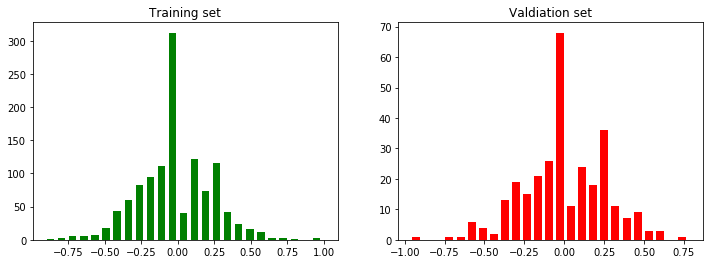

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(PU_lab, bins=num_bins, width=0.05, color='green')
ax[0].set_title('Training set')
ax[1].hist(PW_lab, bins=num_bins, width=0.05, color='red')
ax[1].set_title('Valdiation set')




In [0]:
def preprocess(img_path):
  img = npimg.imread(img_path)
  # obcinanie niepotrzebnej czesci zdjec
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  # reduce noise by averaging
  img = cv2.GaussianBlur(img, (3,3), 0)
  # rozmiar proponowany dla modelu nvidia
  img = cv2.resize(img, (200, 66))
  img = img / 255
  return img


In [0]:
PU =  np.array(list(map(preprocess, PU)))
PW =  np.array(list(map(preprocess, PW)))

![alt text](https://miro.medium.com/max/580/1*JKDXxMxiEtiySMg1yeTibw.png)

![alt text](https://ml-cheatsheet.readthedocs.io/en/latest/_images/elu.png)

In [0]:
def nvidia_model():
  model = Sequential()
  # jadro 2x2                                                         y     x
  model.add(Conv2D(24, kernel_size=(5, 5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, kernel_size=(5, 5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5, 5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
  # dead relu 
  model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))
  optimizer = Adam(lr=0.001)
  # mean square error
  model.compile(loss='mse', optimizer=optimizer)

  return model


In [0]:
model = nvidia_model()

In [150]:
history = model.fit(PU, PU_lab, epochs=30, validation_data=(PW, PW_lab), batch_size=100, verbose=1, shuffle=1)

Train on 1198 samples, validate on 300 samples
Epoch 1/30
1198/1198 [==============================] - 10s 8ms/step - loss: 0.5545 - val_loss: 0.0669
Epoch 2/30
1198/1198 [==============================] - 9s 8ms/step - loss: 0.1379 - val_loss: 0.0639
Epoch 3/30
1198/1198 [==============================] - 9s 7ms/step - loss: 0.0916 - val_loss: 0.0615
Epoch 4/30
1198/1198 [==============================] - 9s 7ms/step - loss: 0.0783 - val_loss: 0.0590
Epoch 5/30
1198/1198 [==============================] - 9s 7ms/step - loss: 0.0686 - val_loss: 0.0564
Epoch 6/30
1198/1198 [==============================] - 9s 7ms/step - loss: 0.0629 - val_loss: 0.0546
Epoch 7/30
1198/1198 [==============================] - 9s 7ms/step - loss: 0.0644 - val_loss: 0.0529
Epoch 8/30
1198/1198 [==============================] - 9s 7ms/step - loss: 0.0598 - val_loss: 0.0506
Epoch 9/30
1198/1198 [==============================] - 9s 7ms/step - loss: 0.0592 - val_loss: 0.0479
Epoch 10/30
1198/1198 [===========

Text(0.5, 1.0, 'Loss')

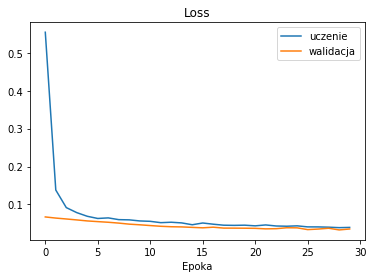

In [168]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['uczenie', 'walidacja'])
plt.xlabel('Epoka')
plt.title('Loss')

In [0]:
model.save('test5.h5')

In [0]:
from google.colab import files
files.download('test5.h5')

array([[-0.0155058]], dtype=float32)

array([[0.41401646]], dtype=float32)

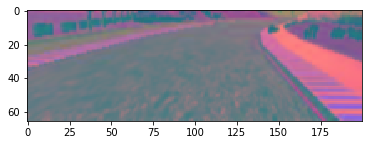

In [133]:
ran = random.randint(0, len(PU) - 1)
plt.imshow(PU[ran])
model.predict(np.asarray([PU[ran]]))
